In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


2024-05-16 14:05:36.449503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 14:05:36.449640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 14:05:36.629493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.__version__)

2.15.0


In [3]:
df_temp = pd.read_csv("/kaggle/input/residential-power-usage-3years-data-timeseries/power_usage_2016_to_2020.csv")
df_temp.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [4]:
df = pd.read_csv("/kaggle/input/residential-power-usage-3years-data-timeseries/power_usage_2016_to_2020.csv", 
                 parse_dates=["StartDate"], 
                 index_col=["StartDate"])

df.head()

,Value (kWh),day_of_week,notes
StartDate,,,
2016-01-06 00:00:00,1.057,2,weekday
2016-01-06 01:00:00,1.171,2,weekday
2016-01-06 02:00:00,0.560,2,weekday
2016-01-06 03:00:00,0.828,2,weekday
2016-01-06 04:00:00,0.932,2,weekday


In [5]:
df.tail()

,Value (kWh),day_of_week,notes
StartDate,,,
2020-07-07 19:00:00,1.307,1,weekday
2020-07-07 20:00:00,2.872,1,weekday
2020-07-07 21:00:00,2.138,1,weekday
2020-07-07 22:00:00,2.199,1,weekday
2020-07-07 23:00:00,1.809,1,weekday


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35952 entries, 2016-01-06 00:00:00 to 2020-07-07 23:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value (kWh)  35952 non-null  float64
 1   day_of_week  35952 non-null  int64  
 2   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
df.isnull().sum()

Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value (kWh),35952.0,0.891631,0.908133,0.064,0.32375,0.501,1.072,6.446
day_of_week,35952.0,2.997330,1.999024,0.000,1.00000,3.000,5.000,6.000


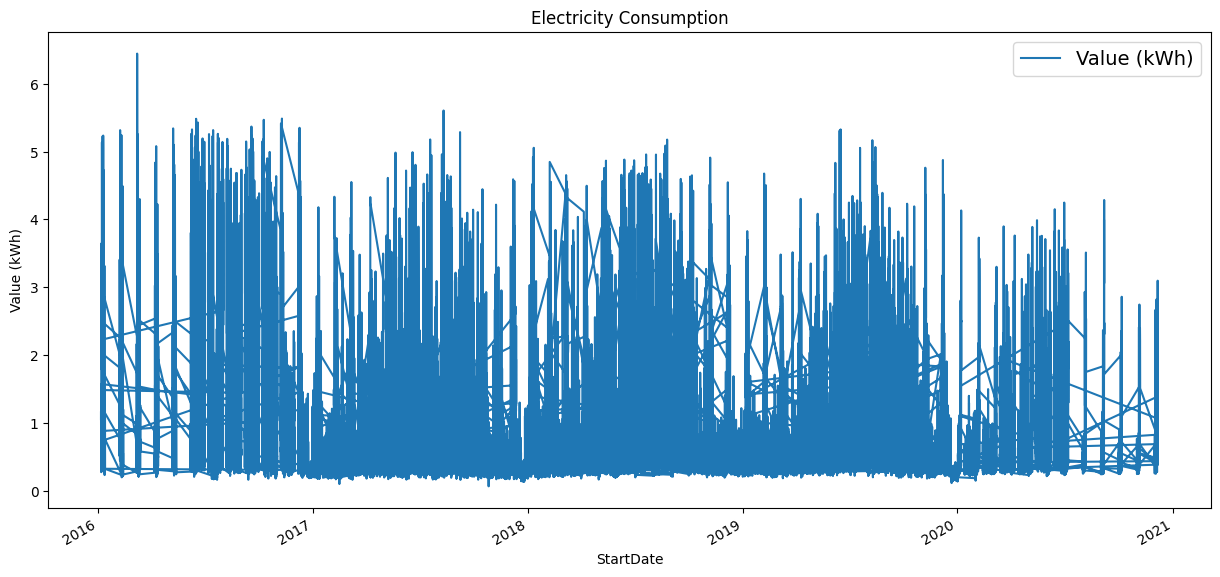

In [9]:
df["Value (kWh)"].plot(figsize=(15,7))
plt.ylabel("Value (kWh)")
plt.title("Electricity Consumption")
plt.legend(fontsize=14)

In [10]:
# Resample the DataFrame by month and calculate the mean
monthly_avg_consumption = df['Value (kWh)'].resample('M').mean()
monthly_avg_consumption.head()



/tmp/ipykernel_32/877810373.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_consumption = df['Value (kWh)'].resample('M').mean()


StartDate
2016-01-31    1.470280
2016-02-29    1.326768
2016-03-31    1.275690
2016-04-30    1.313643
2016-05-31    1.447935
Freq: ME, Name: Value (kWh), dtype: float64

<Axes: title={'center': 'Monthly Electricity Average Consumption'}, xlabel='Month', ylabel='Average Electricity Consumption'>

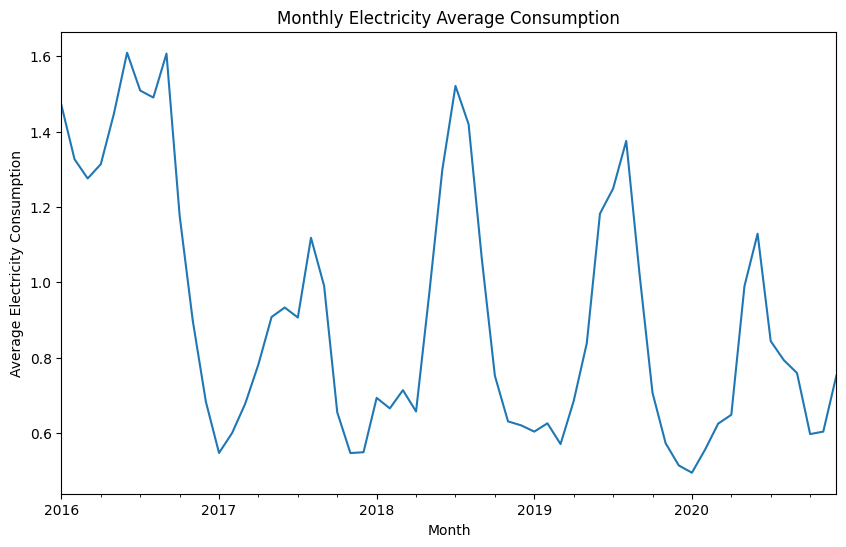

In [11]:
monthly_avg_consumption.plot(kind='line', figsize=(10, 6), xlabel='Month', ylabel='Average Electricity Consumption', title='Monthly Electricity Average Consumption')

<Axes: title={'center': 'Weekly Electricity Average Consumption'}, xlabel='Month', ylabel='Average Electricity Consumption'>

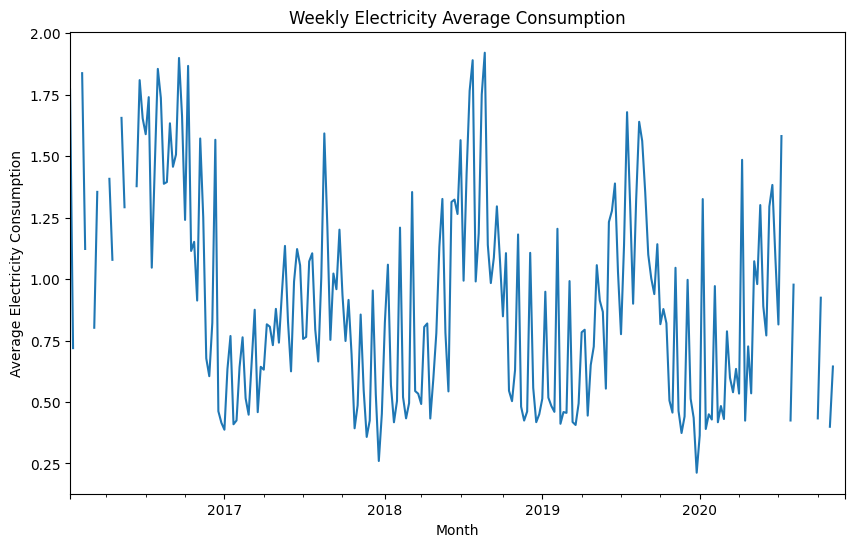

In [12]:
weekly_avg_consumption = df['Value (kWh)'].resample('W').mean()
weekly_avg_consumption.plot(kind='line', figsize=(10, 6), xlabel='Month', ylabel='Average Electricity Consumption', title='Weekly Electricity Average Consumption')

/tmp/ipykernel_32/845261780.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg_consumption = df['Value (kWh)'].resample('Q').mean()


<Axes: title={'center': 'Quarterly Electricity Average Consumption'}, xlabel='Month', ylabel='Average Electricity Consumption'>

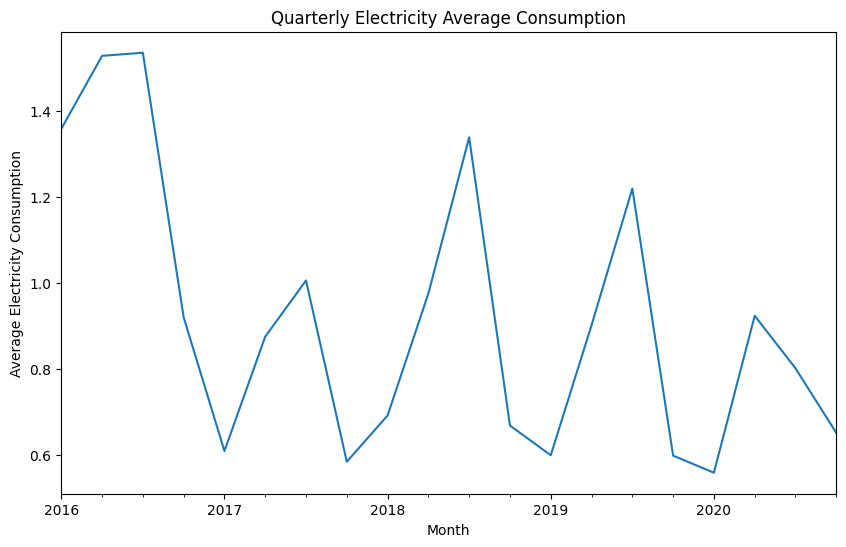

In [13]:
quarterly_avg_consumption = df['Value (kWh)'].resample('Q').mean()
quarterly_avg_consumption.plot(kind='line', figsize=(10, 6), xlabel='Month', ylabel='Average Electricity Consumption', title='Quarterly Electricity Average Consumption')

In [14]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [16]:
df.notes.value_counts()

notes
weekday           23299
weekend            9215
COVID_lockdown     2305
vacation           1133
Name: count, dtype: int64

In [17]:
df.head()

,Value (kWh),day_of_week,notes
StartDate,,,
2016-01-06 00:00:00,1.057,2,weekday
2016-01-06 01:00:00,1.171,2,weekday
2016-01-06 02:00:00,0.560,2,weekday
2016-01-06 03:00:00,0.828,2,weekday
2016-01-06 04:00:00,0.932,2,weekday


In [23]:
# Convert 'category' column to dummy variables
onehot_encoded_df = pd.get_dummies(df['notes'], prefix='is')

# Concatenate dummy variables DataFrame with original DataFrame
result_df = pd.concat([df, onehot_encoded_df], axis=1)
result_df = result_df.drop(columns=['notes'])
result_df.head()

,Value (kWh),day_of_week,is_COVID_lockdown,is_vacation,is_weekday,is_weekend
StartDate,,,,,,
2016-01-06 00:00:00,1.057,2,False,False,True,False
2016-01-06 01:00:00,1.171,2,False,False,True,False
2016-01-06 02:00:00,0.560,2,False,False,True,False
2016-01-06 03:00:00,0.828,2,False,False,True,False
2016-01-06 04:00:00,0.932,2,False,False,True,False


In [25]:
# Convert boolean values to integers (False=0, True=1)
result_df['is_COVID_lockdown'] = result_df['is_COVID_lockdown'].astype(int)
result_df['is_vacation'] = result_df['is_vacation'].astype(int)
result_df['is_weekend'] = result_df['is_weekend'].astype(int)
result_df['is_weekday'] = result_df['is_weekday'].astype(int)
result_df.head()

,Value (kWh),day_of_week,is_COVID_lockdown,is_vacation,is_weekday,is_weekend
StartDate,,,,,,
2016-01-06 00:00:00,1.057,2,0,0,1,0
2016-01-06 01:00:00,1.171,2,0,0,1,0
2016-01-06 02:00:00,0.560,2,0,0,1,0
2016-01-06 03:00:00,0.828,2,0,0,1,0
2016-01-06 04:00:00,0.932,2,0,0,1,0


In [26]:
# Make a copy of the Bitcoin historical data with block reward feature
df_windowed = result_df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    df_windowed[f"Value (kWh)+{i+1}"] = df_windowed["Value (kWh)"].shift(periods=i+1)
df_windowed.head(10)

,Value (kWh),day_of_week,is_COVID_lockdown,is_vacation,is_weekday,is_weekend,Value (kWh)+1,Value (kWh)+2,Value (kWh)+3,Value (kWh)+4,Value (kWh)+5,Value (kWh)+6,Value (kWh)+7
StartDate,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2,0,0,1,0,1.057,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2,0,0,1,0,1.171,1.057,NaN,NaN,NaN,NaN,NaN
2016-01-06 03:00:00,0.828,2,0,0,1,0,0.560,1.171,1.057,NaN,NaN,NaN,NaN
2016-01-06 04:00:00,0.932,2,0,0,1,0,0.828,0.560,1.171,1.057,NaN,NaN,NaN
2016-01-06 05:00:00,0.333,2,0,0,1,0,0.932,0.828,0.560,1.171,1.057,NaN,NaN
2016-01-06 06:00:00,0.462,2,0,0,1,0,0.333,0.932,0.828,0.560,1.171,1.057,NaN
2016-01-06 07:00:00,0.493,2,0,0,1,0,0.462,0.333,0.932,0.828,0.560,1.171,1.057
2016-01-06 08:00:00,0.325,2,0,0,1,0,0.493,0.462,0.333,0.932,0.828,0.560,1.171


In [28]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = df_windowed.dropna().drop("Value (kWh)", axis=1).astype(np.float32) 
y = df_windowed.dropna()["Value (kWh)"].astype(np.float32)
X.head()

,day_of_week,is_COVID_lockdown,is_vacation,is_weekday,is_weekend,Value (kWh)+1,Value (kWh)+2,Value (kWh)+3,Value (kWh)+4,Value (kWh)+5,Value (kWh)+6,Value (kWh)+7
StartDate,,,,,,,,,,,,
2016-01-06 07:00:00,2.0,0.0,0.0,1.0,0.0,0.462,0.333,0.932,0.828,0.560,1.171,1.057
2016-01-06 08:00:00,2.0,0.0,0.0,1.0,0.0,0.493,0.462,0.333,0.932,0.828,0.560,1.171
2016-01-06 09:00:00,2.0,0.0,0.0,1.0,0.0,0.325,0.493,0.462,0.333,0.932,0.828,0.560
2016-01-06 10:00:00,2.0,0.0,0.0,1.0,0.0,0.294,0.325,0.493,0.462,0.333,0.932,0.828
2016-01-06 11:00:00,2.0,0.0,0.0,1.0,0.0,0.273,0.294,0.325,0.493,0.462,0.333,0.932


In [29]:
# View labels
y.head()

StartDate
2016-01-06 07:00:00    0.493
2016-01-06 08:00:00    0.325
2016-01-06 09:00:00    0.294
2016-01-06 10:00:00    0.273
2016-01-06 11:00:00    0.723
Name: Value (kWh), dtype: float32

In [30]:

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(28756, 28756, 7189, 7189)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

def create_model_checkpoint(model_name,patience=5):
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience)
    checkpoint_callback = ModelCheckpoint(filepath=f"{model_name}.keras", monitor='val_mae', save_best_only=True)
    return [early_stopping_callback,checkpoint_callback]

In [49]:
# Make multivariate time series model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(HORIZON)
], name="model_1")

# Compile
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit
model.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=create_model_checkpoint(model_name="model_1",patience=10))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3638 - mae: 0.3638 - val_loss: 0.2084 - val_mae: 0.2084
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2931 - mae: 0.2931 - val_loss: 0.2070 - val_mae: 0.2070
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2861 - mae: 0.2861 - val_loss: 0.2195 - val_mae: 0.2195
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2923 - mae: 0.2923 - val_loss: 0.2090 - val_mae: 0.2090
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2812 - mae: 0.2812 - val_loss: 0.2090 - val_mae: 0.2090
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2849 - mae: 0.2849 - val_loss: 0.2107 - val_mae: 0.2107
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2875 - mae: 0.2875 - val_loss: 0.2093 - val_mae: 0.2093
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2793 - mae: 0.2793 - val_loss: 0.2082 - val_mae: 0.2082
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [54]:
# Loading the best model
best_model_1 =  tf.keras.models.load_model('model_1.keras')
best_model_1.evaluate(X_test, y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1907 - mae: 0.1907


[0.20701102912425995, 0.20701102912425995]

# LSTM Model
* LSTM layer will throw error Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)
* There are 2 ways to fix the error using np way and tensorflow way

In [56]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((28756, 12), (7189, 12), (28756,), (7189,))

In [60]:
X_train.ndim,X_test.ndim,y_train.ndim,y_test.ndim

(2, 2, 1, 1)

In [72]:
X_train_expanded = tf.expand_dims(X_train,1)
X_test_expanded = tf.expand_dims(X_test,1)
X_train_expanded.ndim,X_train_expanded.shape,X_test_expanded.ndim,X_test_expanded.shape

(3, TensorShape([28756, 1, 12]), 3, TensorShape([7189, 1, 12]))

### Numpy way dimension expansion

In [59]:

# X_train_expanded = np.expand_dims(X_train, axis=1)
# X_test_expanded = np.expand_dims(X_test, axis=1)

# print("Original shape:", X_train.shape)
# print("Expanded shape:", X_train_expanded.shape)

Original shape: (28756, 12)
Expanded shape: (28756, 1, 12)


In [75]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(128,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_lstm.compile( 
        loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

model_lstm.fit(X_train_expanded,y_train,epochs=100,
               batch_size=128,
               validation_data=(X_test_expanded, y_test),
               callbacks=create_model_checkpoint(model_name="model_lstm",patience=10))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.4739 - mae: 0.4739 - val_loss: 0.2038 - val_mae: 0.2038
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2891 - mae: 0.2891 - val_loss: 0.2041 - val_mae: 0.2041
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2828 - mae: 0.2828 - val_loss: 0.2028 - val_mae: 0.2028
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2801 - mae: 0.2801 - val_loss: 0.2029 - val_mae: 0.2029
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2826 - mae: 0.2826 - val_loss: 0.2051 - val_mae: 0.2051
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2846 - mae: 0.2846 - val_loss: 0.2051 - val_mae: 0.2051
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2890 - mae: 0.2890 - val_loss: 0.2030 - val_mae: 0.2030
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2798 - mae: 0.2798 - val_loss: 0.2038 - val_mae: 0.2038
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━

In [78]:
# Loading the best model
best_model_lstm =  tf.keras.models.load_model('model_lstm.keras')
best_model_lstm.evaluate(X_test_expanded, y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1862 - mae: 0.1862


[0.20228822529315948, 0.20228822529315948]

In [85]:

# Make predictions on multivariate data
model_lstm_preds = model_lstm.predict(X_test_expanded)
model_lstm_preds[:10]

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[0.30224854],
       [0.30574122],
       [0.31373978],
       [0.28799513],
       [0.35886723],
       [0.6066149 ],
       [0.721554  ],
       [1.05043   ],
       [1.8289477 ],
       [1.4415781 ]], dtype=float32)

In [87]:
pred_vals=tf.squeeze(model_lstm_preds)
pred_vals[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.30224854, 0.30574122, 0.31373978, 0.28799513, 0.35886723,
       0.6066149 , 0.721554  , 1.05043   , 1.8289477 , 1.4415781 ],
      dtype=float32)>

In [89]:
y_test[:10]

StartDate
2019-12-09 11:00:00    0.290
2019-12-09 12:00:00    0.300
2019-12-09 13:00:00    0.258
2019-12-09 14:00:00    0.339
2019-12-09 15:00:00    0.624
2019-12-09 16:00:00    0.753
2019-12-09 17:00:00    1.078
2019-12-09 18:00:00    2.075
2019-12-09 19:00:00    1.628
2019-12-09 20:00:00    1.933
Name: Value (kWh), dtype: float32

In [88]:
y_vals = np.array(y_test)
y_vals[:10]

array([0.29 , 0.3  , 0.258, 0.339, 0.624, 0.753, 1.078, 2.075, 1.628,
       1.933], dtype=float32)

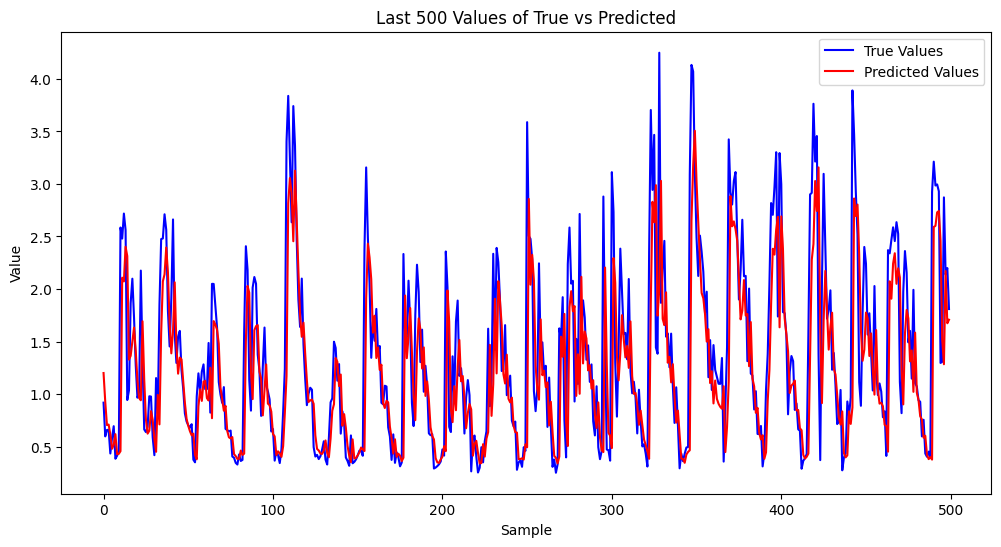

In [90]:
y_test_last_500 = y_vals[-500:]
pred_y_last_500 = pred_vals[-500:]

# Plot the values
plt.figure(figsize=(12, 6))
plt.plot(y_test_last_500, label='True Values', color='blue')
plt.plot(pred_y_last_500, label='Predicted Values', color='red')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Last 500 Values of True vs Predicted')
plt.legend()
plt.show()